In [5]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

In [6]:
df = pd.read_csv('Sunspots.csv',index_col='Date',parse_dates=True) #C:\Users\deeks\OneDrive\Desktop\PROJECT\
df.index.freqs='MS' 

In [7]:
display(df)

,Unnamed: 0,Monthly Mean Total Sunspot Number
Date,,
1749-01-31,0,96.7
1749-02-28,1,104.3
1749-03-31,2,116.7
1749-04-30,3,92.8
1749-05-31,4,141.7
...,...,...
2020-09-30,3260,0.6
2020-10-31,3261,14.4
2020-11-30,3262,34.0


In [8]:
# preparing independent and dependent features
def prepare_data(timeseries_data, n_features):
    X,y =[],[]
    for i in range(len(timeseries_data)):
        #find the end of this pattern
        end_ix = i + n_features
        #check if we are beyond the sequence
        if end_ix > len(timeseries_data)-1:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = timeseries_data[i:end_ix], timeseries_data[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)
            

Processing the data

In [9]:
import csv

# Processing and preparing the data
time_step = []
sunspots = []

with open('Sunspots.csv') as csvfile:  
    reader = csv.reader(csvfile, delimiter=',')  #C:\Users\deeks\OneDrive\Desktop\PROJECT\
    next(reader) # the next() function skips the first line (header) when looping
    for row in reader:
        sunspots.append(float(row[2]))
        time_step.append(int(row[0]))

In [10]:
# For plotting the series or data
def plot_series(time, series, format="-", start=0, end=None, label=None):
    myplot = plt.plot(time[start:end], series[start:end], format, label=label)
    plt.xlabel("Time (Months)")
    plt.ylabel("Average Monthly Sunpots")
    if label != None:
        plt.legend()
    plt.grid(True)

Before plotting, the data gets converted to Numpy arrays

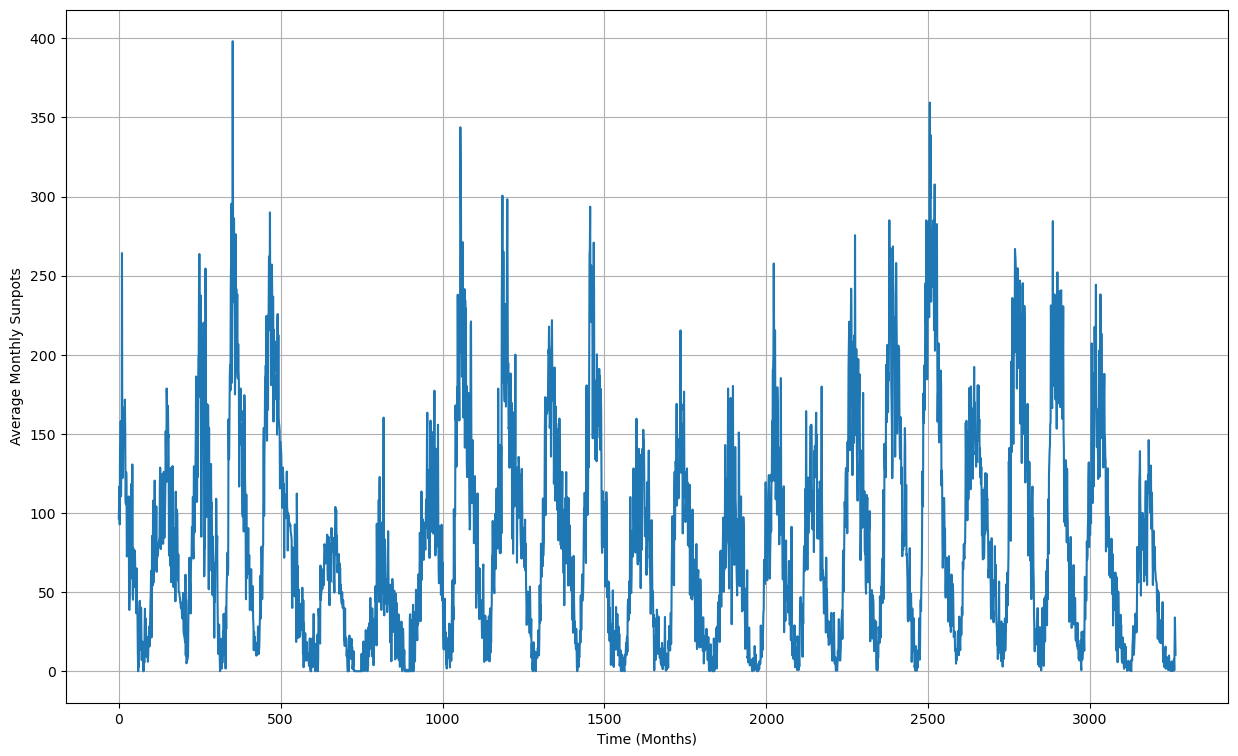

In [11]:
series = np.array(sunspots)
time = np.array(time_step)
#Looking at the data
plt.figure(figsize=(15, 9))
plot_series(time, series)

Pre-Processing

In [12]:
# Adjusting the parameters & preparing the Model
split_time = 3000
window_size= 30
batch_size = 32
shuffle_buffer_zone = 1000

# Training data
#Splitting Training Data into Test and Validation Sets
train_time = time[:split_time]
X_train = series[:split_time]
# Validation data
valid_time = time[split_time:]
X_valid = series[split_time:]
     

Graphing help us understanding the split better

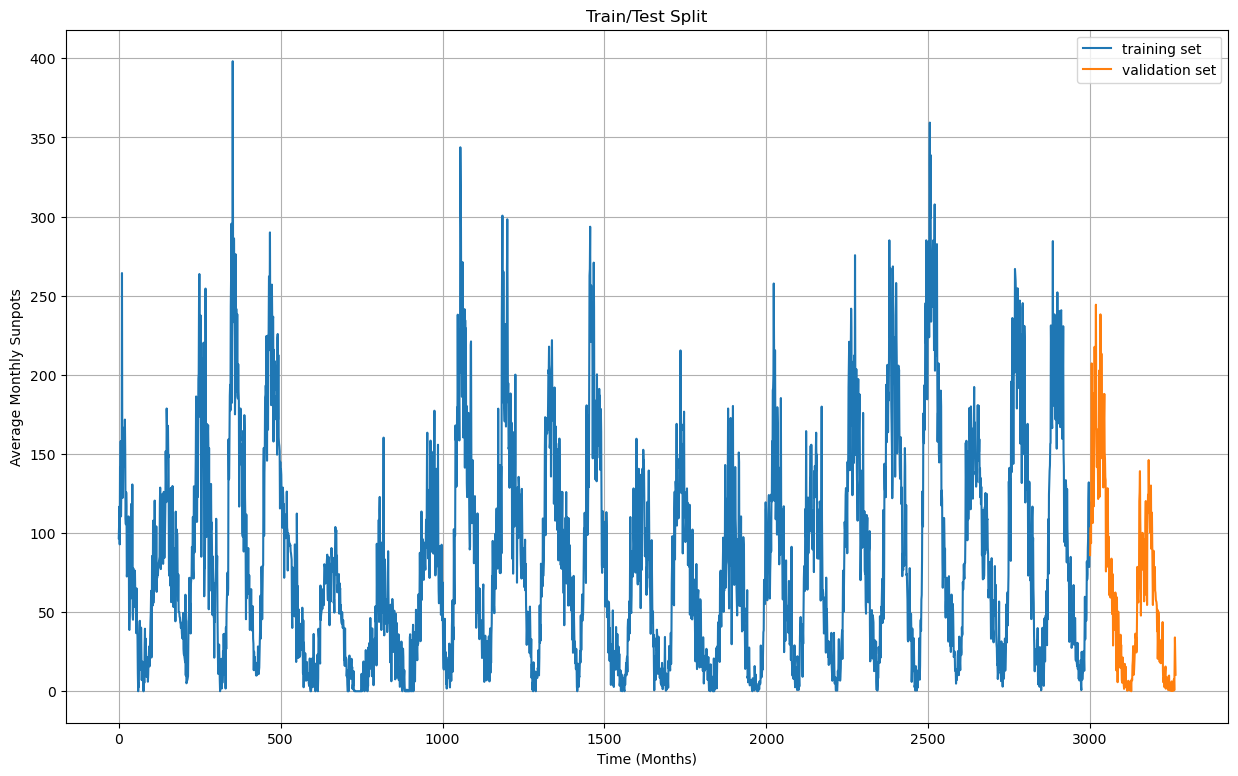

In [13]:
plt.figure(figsize=(15, 9))
plt.title("Train/Test Split")
plot_series(train_time, X_train, label="training set")
plot_series(valid_time, X_valid, label="validation set")

In [14]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

To demonstrate how the windowed_dataset function and the window_size parameter are slicing the data set, have a closer look at the graph below.

In [15]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [16]:
import tensorflow as tf
from tensorflow.keras import regularizers
import numpy as np

# Clear any previous TensorFlow session
tf.keras.backend.clear_session()


tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
window_size = 64
batch_size = 256
shuffle_buffer_zone = 1000
train_set = windowed_dataset(X_train, window_size, batch_size, shuffle_buffer_zone)
print(train_set)
print(X_train.shape)


# Define the CNN-LSTM model with L2 regularization
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(filters=60, kernel_size=5,
                           strides=1, padding="causal",
                           activation="relu",
                           kernel_regularizer=regularizers.l2(0.01),
                           input_shape=[None, 1]),
    tf.keras.layers.LSTM(60, return_sequences=True,
                         kernel_regularizer=regularizers.l2(0.01)),
    tf.keras.layers.LSTM(60, return_sequences=True,
                         kernel_regularizer=regularizers.l2(0.01)),
    tf.keras.layers.Dense(30, activation="relu",
                          kernel_regularizer=regularizers.l2(0.01)),
    tf.keras.layers.Dense(10, activation="relu",
                          kernel_regularizer=regularizers.l2(0.01)),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x * 400)
])

# Define the learning rate scheduler
lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8 * 10**(epoch / 20))

# Define the optimizer with the learning rate
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-8, momentum=0.9)

# Compile the model
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

# Print the model summary
model.summary()

# Fit the model
history = model.fit(train_set, epochs=50, callbacks=[lr_schedule])


<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 1), dtype=tf.float64, name=None), TensorSpec(shape=(None, None, 1), dtype=tf.float64, name=None))>
(3000,)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, None, 60)          360       
                                                                 
 lstm (LSTM)                 (None, None, 60)          29040     
                                                                 
 lstm_1 (LSTM)               (None, None, 60)          29040     
                                                                 
 dense (Dense)               (None, None, 30)          1830      
                                                                 
 dense_1 (Dense)             (None, None, 10)          310       
                                                                 
 dense_2 (Dense)   

In [17]:
'''import tensorflow as tf

tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
window_size = 64
batch_size = 256
shuffle_buffer_zone = 1000
train_set = windowed_dataset(X_train, window_size, batch_size, shuffle_buffer_zone)
print(train_set)
print(X_train.shape)


# Define the CNN-LSTM model
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(filters=60, kernel_size=5,
                           strides=1, padding="causal",
                           activation="relu",
                           input_shape=[None, 1]),
    tf.keras.layers.LSTM(60, return_sequences=True),
    tf.keras.layers.LSTM(60, return_sequences=True),
    tf.keras.layers.Dense(30, activation="relu"),
    tf.keras.layers.Dense(10, activation="relu"),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x * 400)
])

# Compile the model
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=tf.keras.optimizers.SGD(learning_rate=1e-8, momentum=0.9),
              metrics=["mae"])

# Fit the model
history = model.fit(train_set, epochs=150)'''


'import tensorflow as tf\n\ntf.keras.backend.clear_session()\ntf.random.set_seed(51)\nnp.random.seed(51)\nwindow_size = 64\nbatch_size = 256\nshuffle_buffer_zone = 1000\ntrain_set = windowed_dataset(X_train, window_size, batch_size, shuffle_buffer_zone)\nprint(train_set)\nprint(X_train.shape)\n\n\n# Define the CNN-LSTM model\nmodel = tf.keras.models.Sequential([\n    tf.keras.layers.Conv1D(filters=60, kernel_size=5,\n                           strides=1, padding="causal",\n                           activation="relu",\n                           input_shape=[None, 1]),\n    tf.keras.layers.LSTM(60, return_sequences=True),\n    tf.keras.layers.LSTM(60, return_sequences=True),\n    tf.keras.layers.Dense(30, activation="relu"),\n    tf.keras.layers.Dense(10, activation="relu"),\n    tf.keras.layers.Dense(1),\n    tf.keras.layers.Lambda(lambda x: x * 400)\n])\n\n# Compile the model\nmodel.compile(loss=tf.keras.losses.Huber(),\n              optimizer=tf.keras.optimizers.SGD(learning_rate=1

In [18]:
model.summary() 

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, None, 60)          360       
                                                                 
 lstm (LSTM)                 (None, None, 60)          29040     
                                                                 
 lstm_1 (LSTM)               (None, None, 60)          29040     
                                                                 
 dense (Dense)               (None, None, 30)          1830      
                                                                 
 dense_1 (Dense)             (None, None, 10)          310       
                                                                 
 dense_2 (Dense)             (None, None, 1)           11        
                                                                 
 lambda (Lambda)             (None, None, 1)           0

101/101 [==============================] - 3s 20ms/step
First 10 Predictions : 
 [127.11599  122.74591  128.39734  127.998375 122.66449  125.44293
 125.67041  131.79817  135.32156  128.19312 ]

mae :  16.071144


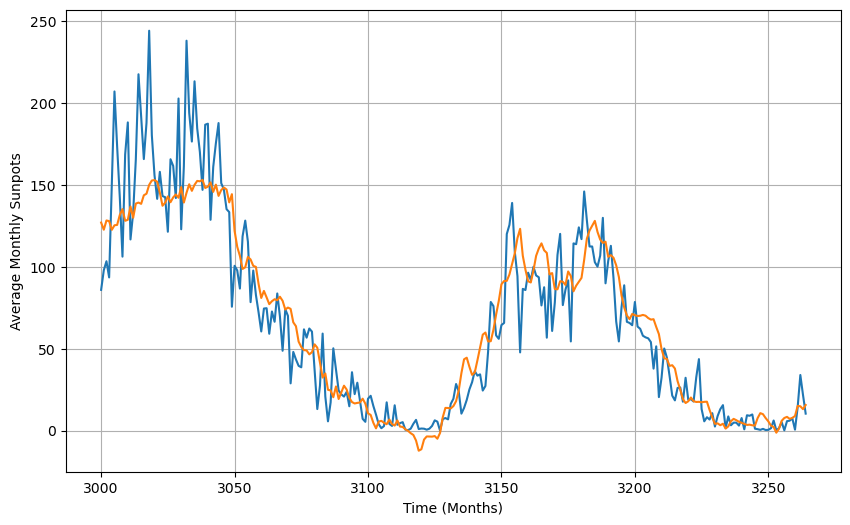

In [19]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]
print("First 10 Predictions :","\n", rnn_forecast[:10])
print('')
print("mae : ", tf.keras.metrics.mean_absolute_error(X_valid, rnn_forecast).numpy())

plt.figure(figsize=(10, 6))
plot_series(valid_time, X_valid)
plot_series(valid_time, rnn_forecast)

Forecasting and Evaluating Here, we see the last sun-spot cycle and how the model (orange) at least visually matches the training/validation (blue) data quite well.

In [28]:
# Calculating the mean absolute error
print('Mean Absolute Error (MAE): ',tf.keras.metrics.mean_absolute_error(X_valid, rnn_forecast).numpy())

Mean Absolute Error (MAE):  16.071144


In [29]:
for i in range(10,20):
    print(X_valid[i], " - ", rnn_forecast[i])

188.3  -  128.80682
116.8  -  136.96608
133.1  -  130.01
165.7  -  138.7033
217.7  -  139.3244
191.5  -  138.54459
165.9  -  143.76544
188.0  -  144.7443
244.3  -  150.14156
180.5  -  152.80623


In [30]:
print(X_valid.shape)
print(rnn_forecast.shape)

from sklearn.metrics import mean_squared_error
from math import sqrt
mse=mean_squared_error(X_valid,rnn_forecast)
print("mse = ", mse)
rmse=sqrt(mse)
print("rmse = ", rmse)

(265,)
(265,)
mse =  523.0105669855864
rmse =  22.869424281900635


In [31]:
# Define the number of future time steps to forecast
future_steps = 100

# Function to generate forecasts
def generate_forecasts(model, series, window_size, future_steps):
    # Create a copy of the series to hold the forecasted values
    forecast_series = series.copy()
    
    # Iterate over the number of future steps to forecast
    for step in range(future_steps):
        # Extract the most recent window from the series
        recent_window = forecast_series[-window_size:]
        
        # Reshape the window to match the input shape expected by the model
        recent_window = recent_window.reshape(1, -1, 1)
        
        # Predict the next value using the model
        next_value = model.predict(recent_window)[0, -1, 0]
        
        # Append the predicted value to the forecast series
        forecast_series = np.append(forecast_series, next_value)
    
    return forecast_series

# Generate forecasts using the trained model and the training set
train_forecasts = generate_forecasts(model, X_train, window_size, future_steps)



1/1 [==============================] - 0s 25ms/step


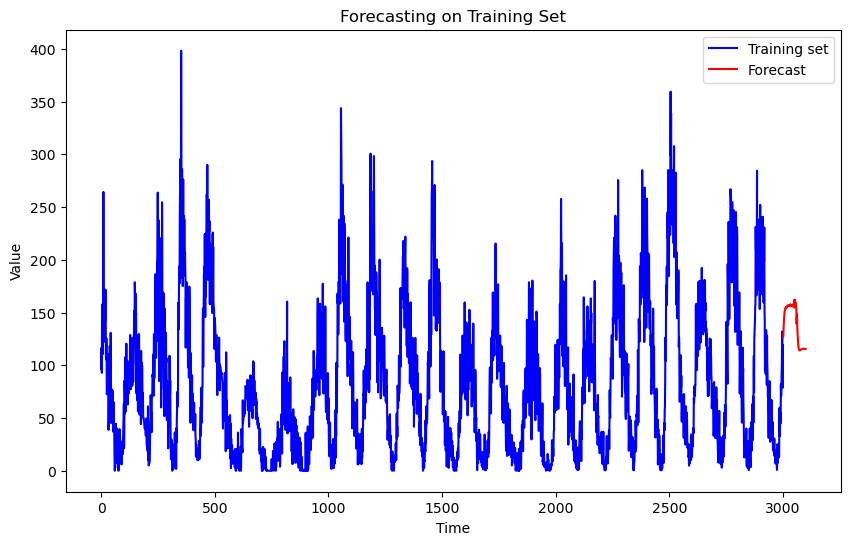

In [33]:
# Plot the original series and the forecasted values
plt.figure(figsize=(10, 6))
plt.plot(time[:len(X_train)], X_train, label='Training set', color='blue')
plt.plot(time[len(X_train):len(X_train)+future_steps], train_forecasts[-future_steps:], label='Forecast', color='red')
plt.title('Forecasting on Training Set')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()
